In [138]:
import numpy as np
import pptk
import networkx as nx
import imageio
import glob
import re
from random import sample
from scipy.spatial import distance
from time import strftime
import os
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
import time
import copy
from moving_least_square import *
from tempfile import TemporaryFile
from collections import defaultdict


In [2]:
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [3]:
# given the data points, return the MST of the point cloud generated from the PNG files and an array 
# of points positions
def getMSTFromDataPoint(data, drawMST: bool, sampleNumber: int=5000):
    # Read points data from PNGs 
    if(sampleNumber > len(data)):
        sampleNumber = len(data)
        
    # default sample 5000 points from the whole set, otherwise it would take too long
    print("---------------")
    print("There are " + str(len(data)) + " points in total. Now sampleling " + str(sampleNumber) + " points from them")
    sample_data = np.asarray(sample(list(data), sampleNumber))
    print("---------------")
    print("Done!")
    #display the points 
    displayPoints(sample_data, 1.3)
    #Create a networkX graph instance that represent MST
    print("---------------")
    print("Begin creating a MST of the sampled points cloud")
    MST = CreateMSTGraph(sample_data)
    print("---------------")
    print("MST creation Done!")
    if(drawMST):
        nx.draw(MST, dict(enumerate(sample_data[:, :2])))
    return (MST, sample_data)
    

In [4]:
def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)

In [5]:
def readPointFromTXT(filepath):
    data = np.genfromtxt(fname=filepath, skip_header=0)
    return data

In [6]:
def ReadPointFromPNG(filepath):
    path_list = [im_path for im_path in glob.glob(filepath)]
    if system_win:
        path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    else:
        path_list_parsed = [re.split('/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    data_valid = []
    delta = 0.5
    thickness = len(path_list_parsed_valid) * 3 * delta
    for path in path_list_parsed_valid:
        s = ""
        if system_win:
            s = "\\"
        else:
            s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        for row in range(len(image)):
            for col in range(len(image)):
                if image[row][col] > 100:
                    data_valid.append([row, col, thickness])
        thickness -= 3*delta
    return data_valid

In [7]:
# This function is used to limited the number of edges in the original graph.
# Instead of creating a graph with full connectivity, this function will return 
# a list of neighbor points for each point and we will only connect them in the graph
def getNearbyPoints(pointsData):
    D = distance.squareform(distance.pdist(pointsData))
    closestIndicies = np.argsort(D, axis=1)
    closestDis = np.sort(D, 1)
    threshold = 10 # This number can be changed. The greater this number, the more edges
    return (closestIndicies[:, 1:threshold], closestDis[:, 1:threshold])

In [8]:
def CreateMSTGraph(pointsData):
    print("---------------")
    print("Begin calculating nearby points for each point")
    nearbyInfo = getNearbyPoints(pointsData)
    print("---------------")
    print("Nearby points calculation Done!")
    print("---------------")
    print("Begin construct graph")
    G=nx.Graph()
    closestIndicies = nearbyInfo[0]
    closestDis = nearbyInfo[1]
    for firstPIndex in range(len(closestIndicies)):
        for second in range(len(closestIndicies[firstPIndex])):
            secondPIndex = closestIndicies[firstPIndex][second]
            G.add_edge(firstPIndex, secondPIndex , weight = closestDis[firstPIndex][second])
    print("---------------")
    print("Graph construction Done!")
    print("---------------")
    print("Begin calculate MST")
    G = nx.minimum_spanning_tree(G)
    print("---------------")
    print("MST calculation Done!")
    return G

In [9]:
# Impliment the collect algorithm for 3D points in the paper
def collectPoints1(P: int, PStar: int):
    global H_glo
    global graph
    global pointsCor3D
    global A

    A.append(P)
    for edge in graph.edges(P):
        Pj = edge[1]
        if(Pj) not in A and distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar]) < H_glo:
            collectPoints1(Pj, PStar)

In [10]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 
def collectPointsNonrec(PStar: int):
    
    global graph
    global pointsCor3D
    global distance_dict 
    global dirty_dict
    global H_glo
    
    toExplore = [PStar]
    A = [PStar]
    distance_dict[(PStar, PStar)] = 0
    weight_dict[((PStar, PStar))] = 1
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        for edge in graph.edges(curP):
            Pj = edge[1]
            if(Pj) not in A:
                
                # Maintain the dictionary of distance and weight between points
                if (Pj, PStar) not in distance_dict or (PStar, Pj) not in distance_dict or \
                dirty_dict[PStar] == 1 or dirty_dict[Pj] == 1:
                    dist_temp = distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar])
                    distance_dict[(Pj, PStar)] = dist_temp
                    distance_dict[(PStar, Pj)] = dist_temp
                    weight_dict[((PStar, Pj))] = weightFun(PStar, Pj)
                    weight_dict[((Pj, PStar))] = weightFun(PStar, Pj)
                    dirty_dict[Pj] = 0
                    dirty_dict[PStar] = 0
                    
                if distance_dict[(Pj, PStar)] < H_glo:
                    toExplore.append(Pj)
                    A.append(Pj)
    return A

In [11]:
def weightFun(P1, P2):
    global distance_dict 
    global dirty_dict
    global pointsCor3D
    if(P1 == P2):
        return 1
    return math.exp(-1 * (distance_dict[(P1, P2)]**2)/(H_glo**2))

In [12]:
def calculateRegressionPlane(PStar, A: list):
    global pointsCor3D
    global H_glo
    global weight_dict
    
    '''
    for point in A:
        if (PStar, point) not in weight_dict or dirty_dict[point] == 1 or dirty_dict[PStar]:
            weight_dict[((PStar, point))] = weightFun(PStar, point)
            weight_dict[((point, PStar))] = weightFun(PStar, point)
    '''
    
    def f(params):
        a, b, c = params 
        loss = 0
        for point in A:
            point_cor = pointsCor3D[point]
            loss += ((a*point_cor[0] + b*point_cor[1] + c - point_cor[2])**2)*weight_dict[((point, PStar))]
            #loss += ((a*point_cor[0] + b*point_cor[1] + c - point_cor[2])**2)*weightFun(PStar, point)
        return loss
    
    initial_guess = [1, 1, 1]
    result = optimize.minimize(f, initial_guess, method = 'Nelder-Mead')
    if result.success:
        fitted_params = result.x
    else:
        raise ValueError(result.message)
    return fitted_params

In [13]:
def projectPoints(params, A: list):
    global pointsCor3D
    a, b, c = params
    normal = np.asarray([a, b, -1])
    normal = normal / np.linalg.norm(normal)
    pointOnPlane = np.asarray([0, 0, c])
    projectionPointsCor = []
    for point in A:
        point_cor = np.asarray(pointsCor3D[point])
        pointToPlaneV = point_cor - pointOnPlane
        dist = np.dot(normal, pointToPlaneV)
        projectionPointcor = point_cor - dist*normal
        projectionPointsCor.append(list(projectionPointcor))
    return projectionPointsCor

In [14]:
# this function converted the 3D coordinate system of points in a plane to 2D, returns a list of new coordinates
# each of them also has x, y and z component but z is equal to 0
# this finction also will return the info of the plane, which can be used to convert a 2D coordinate to 3D again
# The format of the plane info is [u, v, origin] (u is a unit vector in 3D representing plane's x axis, y is a unit 
# vector in 3D representing plane's y axis, origin is a coordinate in 3D of plane's origin )
def convertTo2DCor(pointsCor, planeParam):
    a, b, c = planeParam
    origin = np.array([0, 0, c])
    u = np.array([0, 0, c]) - np.array([1, 1, a + b + c])
    u = u / np.linalg.norm(u)
    normal = np.array([a, b, -1])
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    convertedPointsCor = []
    for pointCor in pointsCor:
        oriV = np.array(pointCor) - origin
        new_x = np.dot(oriV, u)
        new_y = np.dot(oriV, v)
        convertedPointsCor.append([new_x, new_y, 0])
    planeInfo = [u, v, origin]
    return (convertedPointsCor, planeInfo)
    

In [15]:
# Param: targetPoint: the index of the point that we want to find its neighbors and their coordinate in 2D 
# Return: the 2D coordinate of the 3D points and the information of the regression plane, which the points are located
# require gloable perameters graph and pointsCor3D

def get2DCorFrom3D(targetPoint):
    
    global graph
    global pointsCor3D
    
    '''
    global A
    A = []
    start = time.time()
    collectPoints1(targetPoint, targetPoint)
    end = time.time()
    print("collectPoints1:")
    print(start - end)
    '''
    #start = time.time()
    localPoints = collectPointsNonrec(targetPoint)
    #end = time.time()
    #print("collectPointsNonrec:")
    #print(start - end)
    #print(localPoints)
    #displayPoints(pointsCor3D[np.asarray(localPoints)], 0.5)
    #start = time.time()
    params = calculateRegressionPlane(targetPoint, localPoints)
    #print(params)
    #end = time.time()
    #print("calculateRegressionPlane:")
    #print(start - end)
    
    '''
    xyz = []
    a, b, c = params
    for x in range(0, 10):
        for y in range(0, 10):
            z = a*x + b*y + c
            xyz.append([x, y, z])
    displayPoints(xyz, 0.5)
    '''          
    #start = time.time()
    projectionPointsCor = projectPoints(params, localPoints)
    #end = time.time()
    #print("projectPoints:")
    #print(start - end)
    #start = time.time()
    points2DCor, planeInfo = convertTo2DCor(projectionPointsCor, params)
    #end = time.time()
    #print("convertTo2DCor:")
    #print(start - end)
    return (points2DCor, planeInfo)

In [16]:
# This function takes a single point's 2D coordinate and transform it into 3D base on the planeInfo
def get3DCorFrom2D(pointCor, planeInfo):
    u, v, origin = planeInfo
    vectorElem1 = pointCor[0]*u
    vectorElem2 = pointCor[1]*v
    newCor = vectorElem1 + vectorElem2 + origin
    return newCor

In [17]:
#compue the line regression
def calculateRegressionLine(pointsCor):
    X = np.array([x[0] for x in pointsCor]).reshape(-1, 1)
    Y = np.array([x[1] for x in pointsCor]).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    return(linear_regressor.coef_[0], linear_regressor.intercept_[0])

In [18]:
def rotatePointsCor(pointsCor, lineCoef):
    pointsCor = np.array(pointsCor)
    theta = math.atan(lineCoef)
    c, s = math.cos(theta), math.sin(theta)
    R = np.array([(c,-s, 1), (s, c, 1)])
    newPointsCor = []
    for point in pointsCor:
        newPointsCor.append(R.dot(point))
    return np.asarray(newPointsCor)

In [19]:
#filePath = "mri_label_2016/*.png"
#pointData = ReadPointFromPNG(filePath)

In [20]:
#np.save('./temp', pointData)

In [21]:
pointData = np.load('./temp.npy')

In [22]:
pointData

array([[122., 222., 195.],
       [122., 223., 195.],
       [122., 224., 195.],
       ...,
       [176., 418.,  54.],
       [176., 419.,  54.],
       [177., 417.,  54.]])

(graph, pointsCor3D) = getMSTFromDataPoint(pointData, drawMST=True, sampleNumber=2500)

In [23]:
(graph, pointsCor3D) = getMSTFromDataPoint(pointData, drawMST=True, sampleNumber=2500)

---------------
There are 818757 points in total. Now sampleling 2500 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!


In [28]:
points_500 = []
for iteration in range(1):
    H_ini = 20
    H_delta = 5
    H_glo = 0
    trial_limit =10
    min_neighbors = 20
    correlation_threshold = 0.2 + iteration*0.05
    weight_dict = {}
    distance_dict = {}
    dirty_dict = {}
    
    # Set up a dirty dictionary to record the points 
    for point in range(len(pointsCor3D)):
        dirty_dict[point] = 0
    results = []
    
    for targetPoint in range(1000, 1750):
        
        cur_correlation = 0
        H_glo = H_ini
        trial = 0
        correlation_hist = []
        localPointsCor2D_hist = []
        planeInfo = 0
        localPointsCor2D = []
        
        while((cur_correlation < correlation_threshold or len(localPointsCor2D) < min_neighbors) \
              and trial < trial_limit):
            
            localPointsCor2D, planeInfo = get2DCorFrom3D(targetPoint)
            #displayPoints(localPointsCor2D, 0.5)
            slope, intersept = calculateRegressionLine(localPointsCor2D)
            rotatedPointsCor = rotatePointsCor(localPointsCor2D, slope)
            #displayPoints(np.insert(rotatedPointsCor, 2, values=0, axis=1), 0.5)
            cur_correlation = abs(np.corrcoef(rotatedPointsCor[:, 0],rotatedPointsCor[:, 1])[0][1])
            print(targetPoint, "trial",str(trial), "H =", H_glo, ":" , str(cur_correlation), \
                  "size:", len(localPointsCor2D))
            H_glo += H_delta
            trial += 1
            correlation_hist.append(cur_correlation)
            localPointsCor2D_hist.append(copy.deepcopy(localPointsCor2D))
            
        localPointsCor2D = localPointsCor2D_hist[correlation_hist.index(max(correlation_hist))]
        #print(pointsCor3D[targetPoint][:2])
        #print(localPointsCor2D)
        centerPoint2D = np.asarray(localPointsCor2D)[:1, :2]
        #print(centerPoint2D)
        #print(localPointsCor2D)

        newCor = Moving_Least_Square(centerPoint2D[0], np.asarray(localPointsCor2D)[:, :2])
        print(centerPoint2D[0], newCor)
        newCor3D = get3DCorFrom2D(newCor, planeInfo)
        print(pointsCor3D[targetPoint], newCor3D)
        pointsCor3D[targetPoint] = list(newCor3D)
        dirty_dict[targetPoint] = 1
        #if(targetPoint%100 == 0):
            #displayPoints(pointsCor3D, 0.5)
        results.append(max(correlation_hist))
        points_500.append(newCor3D)
    displayPoints(pointsCor3D, 0.5)    
    np.save('./iteration' + str(iteration), pointsCor3D)

1000 trial 0 H = 20 : 0.07645814953679653 size: 42
1000 trial 1 H = 25 : 0.18430297696832562 size: 60
1000 trial 2 H = 30 : 0.32374729912075684 size: 69
[-458.96720625 -186.66691888] [-458.48601948 -186.66529138]
[197.98594074 439.1978984  117.45614565] [198.4231761  438.84170909 116.13361409]
1001 trial 0 H = 20 : 0.33711452933148417 size: 30
[-200.9523385    47.73096024] [-204.07857114   47.76681421]
[174.58271499 109.22947242 149.13856821] [176.90294803 110.92812005 151.38585304]
1002 trial 0 H = 20 : 0.1659746698408239 size: 33
1002 trial 1 H = 25 : 0.41461439263615035 size: 56
[-443.87663028 -182.23702152] [-450.07868358 -182.25568214]
[191.05713191 426.38629098 110.90775939] [195.80983901 430.37217871 112.25322194]
1003 trial 0 H = 20 : 0.20190101667646568 size: 22
[-244.3614969   50.2672012] [-248.50815029   50.32512407]
[204.90973598 133.71462623 166.6299912 ] [206.38088129 135.21352706 157.60766314]
1004 trial 0 H = 20 : 0.25070071110797254 size: 13
1004 trial 1 H = 25 : 0.046

[-257.74848261  -74.83108807] [-254.55080968  -74.80328254]
[124.87904569 230.70368465 179.69362389] [122.64439482 228.4314168  180.10086359]
1031 trial 0 H = 20 : 0.007600730777669684 size: 10
1031 trial 1 H = 25 : 0.2028350968245728 size: 25
[-216.47956711  125.30326307] [-210.6224562   125.26965166]
[240.38434235  68.74383819 153.54933103] [235.83492997  66.54045963 147.28500191]
1032 trial 0 H = 20 : 0.10536253735580485 size: 32
1032 trial 1 H = 25 : 0.4555658152756671 size: 56
[-477.99783573 -184.12141059] [-476.83794471 -184.11780127]
[187.56866357 435.78980355 106.94150255] [187.25394207 435.16572939 105.77844456]
1033 trial 0 H = 20 : 0.08197055964419435 size: 18
1033 trial 1 H = 25 : 0.17570404638695186 size: 24
1033 trial 2 H = 30 : 0.3448041131517162 size: 47
[-199.11938617  -63.22713207] [-202.352612    -63.25900533]
[ 93.57541587 182.39071242 178.16918551] [ 95.87594729 184.92654041 177.32714011]
1034 trial 0 H = 20 : 0.40994576293953855 size: 29
[-366.75569877 -201.334009

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1036 trial 3 H = 35 : nan size: 1
1036 trial 4 H = 40 : 0.9398166738933199 size: 3
1036 trial 5 H = 45 : 0.33230188038314273 size: 104
[-364.82255522  -92.87079822] [-364.82257988  -92.87080265]
[165.10480407 283.70108897 185.64239476] [189.34491512 320.41053834 166.25590376]
1037 trial 0 H = 20 : 0.06724486168407322 size: 28
1037 trial 1 H = 25 : 0.168496177579111 size: 50
1037 trial 2 H = 30 : 0.33515608865476626 size: 58
[-293.68962636  -73.75680305] [-297.76084065  -73.71595479]
[155.96220242 258.65472523 176.85784425] [159.37005957 261.33548283 175.1364178 ]
1038 trial 0 H = 20 : 0.2780708987618855 size: 29
[-341.77674399  -46.15016776] [-337.87683072  -46.23725586]
[172.44682967 237.12104746 183.17752753] [171.12507619 235.38826568 179.35490386]
1039 trial 0 H = 20 : 0.06571051176839772 size: 57
1039 trial 1 H = 25 : 0.13514952395894705 size: 92
1039 trial 2 H = 30 : 0.161039063037329 size: 118
1039 trial 3 H = 35 : 0.16717268118492265 size: 163
1039 trial 4 H = 40 : 0.2096414199

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1046 trial 0 H = 20 : 0.02508682744960081 size: 16
1046 trial 1 H = 25 : 0.5246782861568585 size: 41
[-529.36787123 -112.05104149] [-529.8662706  -112.05220777]
[279.60418342 437.51563855 153.66464417] [280.14607203 437.96416972 153.11078302]
1047 trial 0 H = 20 : 0.11460080338975366 size: 33
1047 trial 1 H = 25 : 0.14792332812321615 size: 42
1047 trial 2 H = 30 : 0.0988245448737086 size: 78
1047 trial 3 H = 35 : 0.05714672621281512 size: 83
1047 trial 4 H = 40 : 0.013816653068910669 size: 98
1047 trial 5 H = 45 : 0.09058718200144446 size: 105
1047 trial 6 H = 50 : 0.01962052606015674 size: 153
1047 trial 7 H = 55 : 0.05420366012713606 size: 165
1047 trial 8 H = 60 : 0.009923277241513569 size: 175
1047 trial 9 H = 65 : 0.0940134062360984 size: 189
[-304.60179362  -80.14736223] [-303.24414626  -80.16035918]
[159.35053307 270.47422799 172.1984222 ] [155.58573959 268.5919891  175.50151832]
1048 trial 0 H = 20 : 0.054269965285032466 size: 34
1048 trial 1 H = 25 : 0.11365406569629972 size: 

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

[-435.31120359 -220.52609212] [-435.31119248 -220.52611185]
[204.11679803 430.99253771 104.88129961] [170.15099019 448.28026456  92.26539667]
1073 trial 0 H = 20 : nan size: 1
1073 trial 1 H = 25 : nan size: 1
1073 trial 2 H = 30 : nan size: 1
1073 trial 3 H = 35 : nan size: 1
1073 trial 4 H = 40 : 0.5859917913110153 size: 12
1073 trial 5 H = 45 : 0.7932084283373803 size: 19
1073 trial 6 H = 50 : 0.7932084283373803 size: 19
1073 trial 7 H = 55 : 0.7932084283373803 size: 19
1073 trial 8 H = 60 : 0.7932084283373803 size: 19
1073 trial 9 H = 65 : 0.5475379762499284 size: 72
[-444.35380586  101.0955687 ] [-444.35380297  101.09556365]
[359.89674329 239.37788953 145.82203893] [368.49883824 226.01599163 145.80721423]
1074 trial 0 H = 20 : 0.18791173598902114 size: 4
1074 trial 1 H = 25 : 0.18791173598902114 size: 4
1074 trial 2 H = 30 : 0.18791173598902114 size: 4
1074 trial 3 H = 35 : 0.18791173598902114 size: 4
1074 trial 4 H = 40 : 0.07098970021530561 size: 207
1074 trial 5 H = 45 : 0.0627

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1086 trial 0 H = 20 : 0.2795621919705632 size: 55
[-282.23710829  148.98469111] [-282.98826747  148.9918451 ]
[295.95806624  85.41493205 148.14823152] [297.01127053  86.73126512 150.78576461]
1087 trial 0 H = 20 : 0.001990813599828278 size: 61
1087 trial 1 H = 25 : 0.10704718562582917 size: 81
1087 trial 2 H = 30 : 0.08951162031155407 size: 135
1087 trial 3 H = 35 : 0.0017615425849918384 size: 164
1087 trial 4 H = 40 : 0.2858199399705534 size: 253
[-214.40502239   93.45514959] [-216.88172786   93.53531615]
[216.32844497  88.49948938 157.94429301] [218.3084157   89.87446426 159.51510282]
1088 trial 0 H = 20 : 0.5819670900885863 size: 18
1088 trial 1 H = 25 : 0.21569780499071814 size: 41
[-430.93745461 -175.70804978] [-431.30329511 -175.70886918]
[180.08480057 421.96806681  80.19345279] [180.31448429 420.7434555   86.67127405]
1089 trial 0 H = 20 : 0.7679808591700839 size: 3
1089 trial 1 H = 25 : 0.7679808591700839 size: 3
1089 trial 2 H = 30 : 0.7679808591700839 size: 3
1089 trial 3 H =

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

[-279.84810706  112.11857172] [-285.68854245  112.14908786]
[272.8512854  115.82334554 148.64024755] [277.03022977 119.89100388 149.11984531]
1112 trial 0 H = 20 : 0.0787661959715009 size: 38
1112 trial 1 H = 25 : 0.3108049367495831 size: 51
[-443.59787828 -185.7247701 ] [-442.95740037 -185.72236725]
[204.92924215 433.91616918 123.89016888] [205.04615202 433.11336555 122.68176198]
1113 trial 0 H = 20 : 0.1655956899708344 size: 25
1113 trial 1 H = 25 : 0.050319608363404975 size: 43
1113 trial 2 H = 30 : 0.08774898203929929 size: 47
1113 trial 3 H = 35 : 0.4623675129330388 size: 83
[-236.19298738   16.1085093 ] [-234.03290252   16.07701509]
[175.33381969 152.47940538 164.2895097 ] [173.5433755  150.91680413 163.41323337]
1114 trial 0 H = 20 : nan size: 1
1114 trial 1 H = 25 : nan size: 1
1114 trial 2 H = 30 : nan size: 1
1114 trial 3 H = 35 : nan size: 1
1114 trial 4 H = 40 : nan size: 1
1114 trial 5 H = 45 : nan size: 1
1114 trial 6 H = 50 : nan size: 1
1114 trial 7 H = 55 : nan size: 1

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1117 trial 1 H = 25 : 0.20602010053731515 size: 44
[-296.81856158  -62.67840079] [-296.24773938  -62.69727286]
[166.40340573 253.21092613 176.65156805] [165.92621993 252.88569038 177.09881513]
1118 trial 0 H = 20 : 0.01131543732856482 size: 38
1118 trial 1 H = 25 : 0.108419316007577 size: 53
1118 trial 2 H = 30 : 0.26302329316668527 size: 90
[-523.44012012   27.27153459] [-527.17946494   27.291324  ]
[366.93855598 329.29298693 179.89426874] [371.63355235 333.14398229 173.75346071]
1119 trial 0 H = 20 : 0.11482904421389656 size: 43
1119 trial 1 H = 25 : 0.09119498601782738 size: 79
1119 trial 2 H = 30 : 0.04417937462433906 size: 110
1119 trial 3 H = 35 : 0.03906097361662583 size: 136
1119 trial 4 H = 40 : 0.07304695332160172 size: 178
1119 trial 5 H = 45 : 0.19434675198664722 size: 198
1119 trial 6 H = 50 : 0.2476373429755395 size: 216
[-284.30058097  144.31565489] [-284.3166138  144.3157551]
[299.71200488  95.82830923 142.85815969] [300.35326844  96.31002293 147.88448432]
1120 trial 0 

1141 trial 4 H = 40 : 0.28774343847434847 size: 77
[-322.09611968  102.0733198 ] [-319.13872827  102.0606167 ]
[296.13932233 154.90756131 132.47012247] [294.06372876 153.57428264 135.23711792]
1142 trial 0 H = 20 : 0.9068659511109134 size: 5
1142 trial 1 H = 25 : 0.8449802367583062 size: 10
1142 trial 2 H = 30 : 0.8297546772373217 size: 58
[-522.98325251 -136.91614333] [-524.63743567 -136.93423664]
[275.94480182 439.03847639 154.29213597] [259.65382003 452.59911772 148.83497006]
1143 trial 0 H = 20 : 0.39251743487243757 size: 11
1143 trial 1 H = 25 : 0.39251743487243757 size: 11
1143 trial 2 H = 30 : 0.39251743487243757 size: 11
1143 trial 3 H = 35 : 0.39251743487243757 size: 11
1143 trial 4 H = 40 : 0.39251743487243757 size: 11
1143 trial 5 H = 45 : 0.8903735574409577 size: 20
[-307.97488522   59.33178091] [-307.81035711   59.33215982]
[239.0025606  164.0720373  121.38410028] [238.87856316 164.36864224 120.79848671]
1144 trial 0 H = 20 : 0.38603921895199445 size: 13
1144 trial 1 H = 2

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1158 trial 1 H = 25 : 0.30672671559066145 size: 44
[-341.79645387 -133.0357835 ] [-339.49673542 -133.03024153]
[115.39321825 303.51918198 171.00886287] [145.7971612  333.7772728  169.96663945]
1159 trial 0 H = 20 : 0.11820946375712997 size: 38
1159 trial 1 H = 25 : 0.12452523998883944 size: 106
1159 trial 2 H = 30 : 0.07949541618240433 size: 145
1159 trial 3 H = 35 : 0.11218297066354074 size: 181
1159 trial 4 H = 40 : 0.08246437276986202 size: 218
1159 trial 5 H = 45 : 0.16415116109599942 size: 369
1159 trial 6 H = 50 : 0.16620067857878743 size: 412
1159 trial 7 H = 55 : 0.1058874178289851 size: 500
1159 trial 8 H = 60 : 0.11298361189508307 size: 527
1159 trial 9 H = 65 : 0.11310182575878679 size: 545
[-215.85705783   80.85199357] [-216.84596396   80.89610977]
[209.59426222  95.87704279 162.4833976 ] [209.82595772  96.51483809 159.56337688]
1160 trial 0 H = 20 : 0.003343248317742736 size: 26
1160 trial 1 H = 25 : 0.016096334661996014 size: 45
1160 trial 2 H = 30 : 0.15879151740440842 s

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1169 trial 5 H = 45 : 0.5953158972353001 size: 3
1169 trial 6 H = 50 : 0.17002244968523847 size: 5
1169 trial 7 H = 55 : 0.6667021920894534 size: 17
1169 trial 8 H = 60 : 0.029138225339544483 size: 50
1169 trial 9 H = 65 : 0.06383107445367235 size: 67
[-387.37243252 -116.25816724] [-387.3724143  -116.25818117]
[177.64722053 324.47771117 164.89523357] [187.36707908 351.55661683 159.09225722]
1170 trial 0 H = 20 : nan size: 1
1170 trial 1 H = 25 : nan size: 1
1170 trial 2 H = 30 : nan size: 1
1170 trial 3 H = 35 : nan size: 1
1170 trial 4 H = 40 : nan size: 1
1170 trial 5 H = 45 : 1.0 size: 2
1170 trial 6 H = 50 : 1.0 size: 2
1170 trial 7 H = 55 : 1.0 size: 2
1170 trial 8 H = 60 : 1.0 size: 2
1170 trial 9 H = 65 : 1.0 size: 2
[-338.3695468  -247.25117176] [-338.36953462 -247.25118223]
[128.96264005 394.7557557   57.61282568] [ 94.40487802 401.64499763  76.21371343]
1171 trial 0 H = 20 : 0.7287180737945264 size: 10
1171 trial 1 H = 25 : 0.3909988293937007 size: 11
1171 trial 2 H = 30 : 0.

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1182 trial 1 H = 25 : 0.4101847521755291 size: 33
[-302.51196867   20.57190002] [-302.6350795   20.5698985]
[204.68592908 177.93047394 137.26235362] [204.64201013 177.19640667 138.55025078]
1183 trial 0 H = 20 : 0.02411419837580656 size: 35
1183 trial 1 H = 25 : 0.045478148372924965 size: 52
1183 trial 2 H = 30 : 0.1390571238877284 size: 59
1183 trial 3 H = 35 : 0.4000198983159681 size: 71
[-337.62027493 -150.47713391] [-336.86470846 -150.47528237]
[103.32290049 312.45922871 169.50121122] [102.82387928 311.93110166 169.27063953]
1184 trial 0 H = 20 : 0.08361811273836063 size: 8
1184 trial 1 H = 25 : 0.08361811273836063 size: 8
1184 trial 2 H = 30 : 0.09660218133906548 size: 50
1184 trial 3 H = 35 : 0.18253544063393493 size: 52
1184 trial 4 H = 40 : 0.27945365684087503 size: 70
[-301.67514354 -188.07463444] [-302.76983153 -188.04839273]
[ 84.68155442 341.80970409 159.62060607] [ 84.99582642 343.05156809 162.36017497]
1185 trial 0 H = 20 : 0.4739262904788246 size: 50
[-284.54739359  156.

1208 trial 6 H = 50 : 0.09226049536126127 size: 26
1208 trial 7 H = 55 : 0.2833976065413832 size: 33
[-455.71243279  113.17401629] [-458.14809105  113.18673535]
[384.22337127 226.30226717 148.47039454] [385.99020492 228.33886261 148.2683547 ]
1209 trial 0 H = 20 : 0.12614530195375426 size: 33
1209 trial 1 H = 25 : 0.10426748066008935 size: 49
1209 trial 2 H = 30 : 0.029964747408730532 size: 56
1209 trial 3 H = 35 : 0.17589066970941022 size: 113
1209 trial 4 H = 40 : 0.21738973554167174 size: 134
[-548.82127505   16.79732186] [-539.9916348    16.69113639]
[378.81553776 355.29083419 180.06296969] [374.07370776 350.47957218 172.38592798]
1210 trial 0 H = 20 : 0.2449351602846316 size: 31
[-369.90496602 -209.28985724] [-369.5376757 -209.2884535]
[116.22160336 391.52695924 117.50857971] [115.73535275 391.68188745 116.30222025]
1211 trial 0 H = 20 : 0.19465488610887483 size: 34
1211 trial 1 H = 25 : 0.2429374142278933 size: 56
[-398.384399   -195.92496389] [-394.45720943 -195.9138705 ]
[131.9

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1214 trial 0 H = 20 : 0.18906823941370593 size: 30
1214 trial 1 H = 25 : 0.25774702716987347 size: 43
[-345.61705176    8.25981906] [-340.00829505    8.32071264]
[196.49909965 185.17300927 139.89458826] [194.41178458 182.71020969 144.87580165]
1215 trial 0 H = 20 : 0.4401712936053018 size: 38
[-197.84792652   91.04614064] [-200.71365364   91.10405448]
[203.5201148   75.07320672 153.69697917] [205.61978977  77.05429641 153.49295644]
1216 trial 0 H = 20 : 0.8225884075020624 size: 3
1216 trial 1 H = 25 : 0.8225884075020624 size: 3
1216 trial 2 H = 30 : 0.8225884075020624 size: 3
1216 trial 3 H = 35 : 0.8225884075020624 size: 3
1216 trial 4 H = 40 : 0.8225884075020624 size: 3
1216 trial 5 H = 45 : 0.8225884075020624 size: 3
1216 trial 6 H = 50 : 0.3192871849039838 size: 10
1216 trial 7 H = 55 : 0.3192871849039838 size: 10
1216 trial 8 H = 60 : 0.5923196909555074 size: 12
1216 trial 9 H = 65 : 0.6930016091073659 size: 19
[-428.89391558   84.06767001] [-428.89388833   84.06767057]
[340.72911

1236 trial 3 H = 35 : 0.025192128587856095 size: 79
1236 trial 4 H = 40 : 0.29807352703239737 size: 147
[-331.64311208  -89.64860847] [-331.64309754  -89.64860847]
[142.30442971 259.05061477 176.44290533] [169.10820735 295.55906823 171.12369093]
1237 trial 0 H = 20 : 0.86718671994534 size: 17
1237 trial 1 H = 25 : 0.23150783237539213 size: 44
[-303.04174129   -4.35467662] [-303.46964076   -4.35570589]
[184.88862855 190.86234734 147.40188726] [170.37994327 176.51490566 161.13866842]
1238 trial 0 H = 20 : 0.17108194460561943 size: 19
1238 trial 1 H = 25 : 0.26754343579395484 size: 20
[-545.64651758 -115.08931297] [-546.14924547 -115.09053164]
[269.24819473 429.16994717 154.3629792 ] [270.07569997 429.68955175 155.10371471]
1239 trial 0 H = 20 : 0.8297875373627087 size: 20
[-269.30984957  105.01336247] [-275.54628849  103.52593722]
[261.81788342 117.21849093 147.05961849] [264.99292693 123.15143801 146.8458778 ]
1240 trial 0 H = 20 : 0.34443945284876437 size: 22
[-335.97012786 -192.666448

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1248 trial 3 H = 35 : 0.5732126270666805 size: 54
[-357.53493163 -240.19728246] [-357.5349513  -240.19726316]
[139.47172407 400.187934    78.32027933] [ 84.16636164 420.24753393  90.6437614 ]
1249 trial 0 H = 20 : 0.2990779017633008 size: 21
[-518.4492268    34.25694033] [-519.67705628   34.26246976]
[370.90118335 325.30891366 164.86280141] [371.66830261 325.22291203 167.16814099]
1250 trial 0 H = 20 : 0.3572842342729442 size: 19
1250 trial 1 H = 25 : 0.015080086659023996 size: 39
1250 trial 2 H = 30 : 0.15147517972571967 size: 63
1250 trial 3 H = 35 : 0.012861400521748074 size: 80
1250 trial 4 H = 40 : 0.01260539168628708 size: 89
1250 trial 5 H = 45 : 0.2682589607350778 size: 112
[-269.25640244   -0.70019667] [-265.89949876   -0.73789573]
[146.72874967 148.52437243 171.55968598] [187.37974108 188.40466535 169.61926267]
1251 trial 0 H = 20 : 0.30684524217000414 size: 38
[-222.51154488  -60.28759786] [-223.44482238  -60.33759688]
[114.10930187 199.00418291 180.1356952 ] [114.73006942 1

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1265 trial 0 H = 20 : nan size: 1
1265 trial 1 H = 25 : nan size: 1
1265 trial 2 H = 30 : 0.6903670561946917 size: 66
[-375.31053425 -243.65546591] [-375.31056362 -243.65546981]
[111.11417058 405.38043244 154.72734355] [ 95.67996871 436.92074661 160.03306617]
1266 trial 0 H = 20 : 0.07763961669858532 size: 36
1266 trial 1 H = 25 : 0.11033832502373551 size: 70
1266 trial 2 H = 30 : 0.0486270449596116 size: 100
1266 trial 3 H = 35 : 0.02167592181344743 size: 128
1266 trial 4 H = 40 : 0.07012072323961403 size: 184
1266 trial 5 H = 45 : 0.08439962846349787 size: 212
1266 trial 6 H = 50 : 0.0676400810703389 size: 218
1266 trial 7 H = 55 : 0.028022901034160753 size: 224
1266 trial 8 H = 60 : 0.013904567524463557 size: 241
1266 trial 9 H = 65 : 0.08587296942849856 size: 274
[-518.9711995    18.49651274] [-526.02456774   18.43946081]
[363.52151126 339.1705033  152.02438444] [367.51183845 341.86459134 160.22439756]
1267 trial 0 H = 20 : 0.18049605288310902 size: 22
1267 trial 1 H = 25 : 0.03572

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1269 trial 4 H = 40 : nan size: 1
1269 trial 5 H = 45 : nan size: 1
1269 trial 6 H = 50 : nan size: 1
1269 trial 7 H = 55 : nan size: 1
1269 trial 8 H = 60 : nan size: 1
1269 trial 9 H = 65 : 0.09100271206922282 size: 18
[-286.55772921 -143.03356631] [-286.55776488 -143.03354591]
[ 72.90534418 261.25828847 171.46846189] [103.11614517 303.13619802 174.54121992]
1270 trial 0 H = 20 : 0.5921031543570486 size: 20
[-367.40952265 -222.27777236] [-372.46535314 -222.39633943]
[ 87.90328396 402.06440038 105.58726815] [ 90.73541761 405.12732812 102.31548931]
1271 trial 0 H = 20 : 0.02727442892134237 size: 12
1271 trial 1 H = 25 : 0.12654144894970779 size: 41
1271 trial 2 H = 30 : 0.015602830532179828 size: 45
1271 trial 3 H = 35 : 0.018400428753851932 size: 50
1271 trial 4 H = 40 : 0.12942837546763653 size: 59
1271 trial 5 H = 45 : 0.017073676864388748 size: 65
1271 trial 6 H = 50 : 0.0702927735434116 size: 86
1271 trial 7 H = 55 : 0.15562617603815673 size: 89
1271 trial 8 H = 60 : 0.12079065628

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

[-339.09075118  -53.35196799] [-339.09074944  -53.35197736]
[164.04043611 236.90257778 188.09232807] [205.18564824 274.33823003 196.38896956]
1292 trial 0 H = 20 : nan size: 1
1292 trial 1 H = 25 : 0.4984506258175305 size: 43
[-331.75388015  161.21068564] [-331.75385583  161.21067074]
[316.88764438 130.87174584 137.33807049] [344.14183331 116.81447445 142.07113192]
1293 trial 0 H = 20 : 0.018912674342628135 size: 31
1293 trial 1 H = 25 : 0.39090245167543736 size: 57
[-387.68278786 -183.5781058 ] [-385.87848749 -183.57213207]
[143.76729653 402.1832596  118.35082773] [142.4924624  400.92634412 118.6488715 ]
1294 trial 0 H = 20 : 0.027563973670955942 size: 40
1294 trial 1 H = 25 : 0.0013390323685052957 size: 53
1294 trial 2 H = 30 : 0.03747455030631572 size: 62
1294 trial 3 H = 35 : 0.006822610787803337 size: 77
1294 trial 4 H = 40 : 0.00767744726568116 size: 102
1294 trial 5 H = 45 : 0.059490060039582376 size: 107
1294 trial 6 H = 50 : 0.0775018610849366 size: 128
1294 trial 7 H = 55 : 0

1322 trial 3 H = 35 : 0.16691663630583037 size: 84
1322 trial 4 H = 40 : 0.3070054672647408 size: 100
[-502.36464796 -159.13841188] [-495.06491314 -159.12481943]
[230.57438111 452.45886323 142.17230284] [226.38258479 447.77079152 138.015394  ]
1323 trial 0 H = 20 : 0.04212359617524802 size: 8
1323 trial 1 H = 25 : 0.3239955279096939 size: 10
1323 trial 2 H = 30 : 0.6589218367454602 size: 36
[-237.06111859   30.0495567 ] [-227.39864763   29.94999856]
[181.97050631 140.80785101 155.77507821] [176.50066025 134.55684559 162.57751204]
1324 trial 0 H = 20 : 0.22304384461974605 size: 20
[-350.66526591 -225.26542458] [-350.95367275 -225.26662527]
[ 77.52662588 395.56168295 107.3973853 ] [ 76.8585704  395.10009896 110.46992522]
1325 trial 0 H = 20 : 0.32017892905815337 size: 23
[-252.27744168   20.49795957] [-250.53096763   20.46345766]
[179.33459681 151.58871818 160.51005031] [177.92771726 150.45152723 160.68861535]
1326 trial 0 H = 20 : 0.21981892597679567 size: 35
[-341.89165242  139.8341997

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1329 trial 3 H = 35 : 0.1777587226550682 size: 105
1329 trial 4 H = 40 : 0.18612594371804864 size: 119
1329 trial 5 H = 45 : 0.09552323296739773 size: 146
1329 trial 6 H = 50 : 0.053078923245324636 size: 165
1329 trial 7 H = 55 : 0.06809779671239204 size: 174
1329 trial 8 H = 60 : 0.0369368344860233 size: 187
1329 trial 9 H = 65 : 0.03122371185326765 size: 197
[-180.17224104   43.72551838] [-191.39899827   43.43611053]
[158.34415105  96.38811097 154.70091428] [162.31093863 101.04644619 159.72636659]
1330 trial 0 H = 20 : 0.006814372583767674 size: 40
1330 trial 1 H = 25 : 0.282930557039917 size: 61
[-251.09798071   49.79877376] [-249.03700407   49.69154995]
[211.30789605 142.2719286  155.51428292] [209.68724847 141.29687349 157.25384483]
1331 trial 0 H = 20 : 0.32139367124634133 size: 17
1331 trial 1 H = 25 : 0.26584961229192705 size: 36
[-506.35217693   60.99385379] [-508.4072008    60.99882748]
[382.63876503 297.03588597 161.4200883 ] [385.39813494 299.13331225 157.09015505]
1332 tri

1353 trial 4 H = 40 : 0.10256080369818493 size: 164
1353 trial 5 H = 45 : 0.036637185862131647 size: 182
1353 trial 6 H = 50 : 0.08437593190984022 size: 187
1353 trial 7 H = 55 : 0.04713527336597142 size: 198
1353 trial 8 H = 60 : 0.0973969274315737 size: 367
1353 trial 9 H = 65 : 0.09479407780802508 size: 429
[ 72.34980207 249.60229137] [ 72.26044385 249.60246047]
[168.82307187 111.93200174 164.91373326] [ 126.36176832 -225.98954178  123.70822591]
1354 trial 0 H = 20 : 0.04102133295588353 size: 22
1354 trial 1 H = 25 : 0.05234917983260234 size: 45
1354 trial 2 H = 30 : 0.01555551685395689 size: 66
1354 trial 3 H = 35 : 0.2039083852632 size: 75
[-201.94967079   24.66227241] [-206.65527484   24.69281622]
[160.24807631 125.35183025 169.91335708] [163.58059876 128.67440363 169.10502912]
1355 trial 0 H = 20 : 0.1153499901975354 size: 39
1355 trial 1 H = 25 : 0.28213967081223645 size: 60
[-307.07076814  129.41445136] [-305.3638845   129.40802412]
[307.63511125 125.42959075 145.39363272] [30

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1359 trial 0 H = 20 : 0.32819137029927303 size: 47
[-247.86220188   86.69773345] [-246.68900679   86.69129969]
[219.52180128 104.89278494 166.91894219] [219.40626409 104.0154185  168.70585285]
1360 trial 0 H = 20 : 0.02337245728003715 size: 39
1360 trial 1 H = 25 : 0.14142148931752527 size: 50
1360 trial 2 H = 30 : 0.5444779039074444 size: 61
[-516.74163085  -28.63029508] [-517.11260059  -28.62909855]
[330.14094222 370.60832184 148.54321635] [330.58293154 371.06712051 147.68872296]
1361 trial 0 H = 20 : 0.0434171208639363 size: 51
1361 trial 1 H = 25 : 0.016709715376337222 size: 59
1361 trial 2 H = 30 : 0.19080183450145113 size: 75
1361 trial 3 H = 35 : 0.2560037739532056 size: 129
[-544.6664692    24.65661066] [-539.19165594   24.59924513]
[384.40614998 349.15257348 167.89986941] [379.43306828 344.73574654 170.60121965]
1362 trial 0 H = 20 : 0.019563708269927746 size: 23
1362 trial 1 H = 25 : 0.033930497542717215 size: 51
1362 trial 2 H = 30 : 0.02642313588700145 size: 62
1362 trial 3

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1366 trial 2 H = 30 : 0.048697846830818146 size: 48
1366 trial 3 H = 35 : 0.1016993370221668 size: 75
1366 trial 4 H = 40 : 0.4071776141835706 size: 120
[-539.2350386    -1.10842958] [-526.74747394   -1.05520548]
[366.8737294  366.45865974 149.90480395] [356.96846596 358.31735731 149.05646829]
1367 trial 0 H = 20 : 0.7766568750847381 size: 17
1367 trial 1 H = 25 : 0.8546501966150136 size: 20
[-308.21838587  -39.87566448] [-308.14723546  -39.8755261 ]
[146.2942268  201.76517403 187.23537941] [146.39968007 201.99104412 186.78733796]
1368 trial 0 H = 20 : 0.17605889697920052 size: 33
1368 trial 1 H = 25 : 0.13866029139195252 size: 64
1368 trial 2 H = 30 : 0.19036580836473266 size: 74
1368 trial 3 H = 35 : 0.19630998724332155 size: 88
1368 trial 4 H = 40 : 0.609420851214033 size: 111
[-515.57655848 -127.32353737] [-518.06872837 -127.32734718]
[260.96064582 439.82687678 144.64381756] [261.37844876 440.79731732 149.73308186]
1369 trial 0 H = 20 : 0.05965148459678068 size: 36
1369 trial 1 H =

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1375 trial 7 H = 55 : 0.1712335569898543 size: 145
1375 trial 8 H = 60 : 0.17711796435478971 size: 151
1375 trial 9 H = 65 : 0.2203047209499841 size: 172
[-326.3142779  -206.08479593] [-326.31429199 -206.08482101]
[ 79.59826868 342.20999303 160.93772097] [ 83.14712479 371.03701717 157.84070741]
1376 trial 0 H = 20 : 0.40429272511556397 size: 18
1376 trial 1 H = 25 : 0.4610427349657344 size: 36
[-417.34916357 -180.06537003] [-425.26795222 -180.09075998]
[163.43034943 415.44206576  87.76142611] [168.95387679 421.07810215  88.524     ]
1377 trial 0 H = 20 : 0.7570151883159988 size: 22
[-509.81237727  -25.95208205] [-509.71722448  -25.95225431]
[327.49958999 363.82984191 146.65072251] [327.52847226 363.99147021 145.83939355]
1378 trial 0 H = 20 : 0.2599547988454265 size: 20
[-269.10330602   83.97982504] [-266.15792849   83.91591638]
[219.28445808 101.14907638 158.8882504 ] [220.75222157 102.18607743 167.80249308]
1379 trial 0 H = 20 : 0.008215940284907517 size: 31
1379 trial 1 H = 25 : 0.0

1405 trial 0 H = 20 : 0.4361098101523053 size: 24
[-241.60784786   -4.81201405] [-243.56238974   -4.82568208]
[166.86972153 173.65979091 159.73888793] [168.25797329 175.08112337 160.06203668]
1406 trial 0 H = 20 : 0.12941682868638074 size: 33
1406 trial 1 H = 25 : 0.1005063981231082 size: 41
1406 trial 2 H = 30 : 0.0017168560655747777 size: 80
1406 trial 3 H = 35 : 0.048483292069712074 size: 103
1406 trial 4 H = 40 : 0.07500822237126817 size: 144
1406 trial 5 H = 45 : 0.32022573758181505 size: 246
[-210.69078439  107.41143002] [-221.81557698  109.97859196]
[222.93345395  76.38897528 151.86168919] [232.99980125  81.91231964 154.63235589]
1407 trial 0 H = 20 : 0.19522193268256632 size: 29
1407 trial 1 H = 25 : 0.03425021312074524 size: 35
1407 trial 2 H = 30 : 0.003748939204286192 size: 76
1407 trial 3 H = 35 : 0.036281353777073984 size: 87
1407 trial 4 H = 40 : 0.07146512130807905 size: 110
1407 trial 5 H = 45 : 0.11265384517365258 size: 155
1407 trial 6 H = 50 : 0.3146200453973184 size

[-517.29621522   62.74705429] [-509.84867089   62.72686726]
[392.8653886  306.933679   153.51970236] [387.31732271 300.02192718 156.2660481 ]
1430 trial 0 H = 20 : 0.10816630626756865 size: 28
1430 trial 1 H = 25 : 0.40568531206887093 size: 40
[-303.9368524    12.22792281] [-302.79905808   12.21250402]
[198.80880087 183.98816207 140.11153807] [197.61065549 181.09625729 143.05215424]
1431 trial 0 H = 20 : 0.4382071249642065 size: 29
[-210.23916569  -62.42578822] [-210.1936577   -62.42534301]
[103.73581588 191.53823161 179.460649  ] [103.70184498 191.55459453 179.09422843]
1432 trial 0 H = 20 : 0.016518295270885146 size: 35
1432 trial 1 H = 25 : 0.1018365148452317 size: 43
1432 trial 2 H = 30 : 0.2865137973397992 size: 55
[-380.41957675 -200.9372696 ] [-372.77891851 -200.91737607]
[127.50272075 408.56944911 150.98019613] [122.80698024 403.30280233 154.77225832]
1433 trial 0 H = 20 : 0.5785258300608697 size: 30
[-443.98950785 -198.41592449] [-444.63363453 -198.40999991]
[194.75959165 445.

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1449 trial 2 H = 30 : nan size: 1
1449 trial 3 H = 35 : nan size: 1
1449 trial 4 H = 40 : nan size: 1
1449 trial 5 H = 45 : nan size: 1
1449 trial 6 H = 50 : nan size: 1
1449 trial 7 H = 55 : 0.02487512019874885 size: 58
1449 trial 8 H = 60 : 0.30041400727968653 size: 86
[-363.98815802 -175.11700345] [-363.98817428 -175.11698177]
[136.07744251 343.79560585 163.89712143] [131.67920439 378.79252007 161.80749315]
1450 trial 0 H = 20 : 0.934509486521079 size: 9
1450 trial 1 H = 25 : 0.8839637242756152 size: 12
1450 trial 2 H = 30 : 0.8232792615986745 size: 14
1450 trial 3 H = 35 : 0.7050378700146402 size: 19
1450 trial 4 H = 40 : 0.3347781809795609 size: 137
[-281.40860775  -81.16427817] [-282.29197375  -81.06613767]
[138.04609478 252.76034499 177.54970316] [140.65362802 254.99421624 177.52743906]
1451 trial 0 H = 20 : 0.04853812531003209 size: 14
1451 trial 1 H = 25 : 0.031651367269373495 size: 76
1451 trial 2 H = 30 : 0.08771727464153992 size: 111
1451 trial 3 H = 35 : 0.1853830702874939

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1452 trial 3 H = 35 : 0.9689771548235716 size: 3
1452 trial 4 H = 40 : 0.004330411551576135 size: 7
1452 trial 5 H = 45 : 0.4703314436400649 size: 122
[-326.98702319  172.11665871] [-326.98702132  172.11665788]
[320.61206718 114.67821566 144.81691256] [347.28205217 103.89407731 139.48775696]
1453 trial 0 H = 20 : 0.11290273911637881 size: 33
1453 trial 1 H = 25 : 0.20208238859131977 size: 55
[-343.23422189 -204.93430585] [-346.3662805  -204.94648862]
[102.38511925 383.43304523 154.16999303] [104.78035697 385.47567539 155.16928941]
1454 trial 0 H = 20 : nan size: 1
1454 trial 1 H = 25 : nan size: 1
1454 trial 2 H = 30 : nan size: 1
1454 trial 3 H = 35 : nan size: 1


/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1454 trial 4 H = 40 : 1.0 size: 2
1454 trial 5 H = 45 : 0.9600647509889468 size: 5
1454 trial 6 H = 50 : 0.287183734480421 size: 142
[-332.35376899  163.90791538] [-332.35376965  163.9078863 ]
[318.08209855 125.50020255 144.1210905 ] [346.8391487  115.351802   139.25885013]
1455 trial 0 H = 20 : 0.3592300723730215 size: 32
[-430.43057813 -169.30464929] [-433.86215975 -169.31747936]
[179.4085523  416.75896383  91.54234593] [181.83495453 419.4876639   90.47317508]
1456 trial 0 H = 20 : 0.23111831429375873 size: 30
[-309.62562535 -118.23297452] [-307.81896868 -118.39522536]
[134.9375683  301.83716507 170.21776124] [133.54502281 300.7190498  170.87305797]
1457 trial 0 H = 20 : 0.32343236093561367 size: 37
[-367.7205482  -213.35778276] [-367.60678237 -213.35745893]
[ 95.18925524 384.02811902 156.84326542] [ 95.13514986 383.65647526 157.5206582 ]
1458 trial 0 H = 20 : 0.7671841913611855 size: 10
1458 trial 1 H = 25 : 0.47357215997017915 size: 21
[-475.56086261 -149.26770479] [-475.97447227 -

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1473 trial 2 H = 30 : 0.11306056789020891 size: 83
1473 trial 3 H = 35 : 0.04549459644663775 size: 105
1473 trial 4 H = 40 : 0.036371119158385985 size: 127
1473 trial 5 H = 45 : 0.20130595668365941 size: 151
[-295.54735212  -71.6533054 ] [-295.54734559  -71.6532803 ]
[118.01914178 215.34809158 180.66899474] [158.65678215 259.21705088 184.41941348]
1474 trial 0 H = 20 : 0.5977945076468442 size: 8
1474 trial 1 H = 25 : 0.7057966904014513 size: 11
1474 trial 2 H = 30 : 0.8069703529990264 size: 14
1474 trial 3 H = 35 : 0.0016395318987343754 size: 47
1474 trial 4 H = 40 : 0.7143233681534195 size: 100
[-175.18144762   33.42286818] [-181.21711676   33.30589058]
[147.47013354 100.29082693 151.60025222] [149.80905928 102.72372748 156.80407092]
1475 trial 0 H = 20 : 0.828978846220575 size: 24
[-292.05554228   65.9321811 ] [-291.4541686    65.93062174]
[210.58438223 118.25236369 178.29449815] [210.40412333 118.16685263 177.57192169]
1476 trial 0 H = 20 : 0.38901577269508886 size: 29
[-369.5450419

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1478 trial 8 H = 60 : 0.05198520318850686 size: 55
1478 trial 9 H = 65 : 0.04774369261920384 size: 57
[-312.38752524   37.36707198] [-312.38750311   37.36705694]
[216.48851078 166.39198631 157.90673336] [240.72943007 188.19692495 154.81465318]
1479 trial 0 H = 20 : 0.07925734779869603 size: 19
1479 trial 1 H = 25 : 0.6305785097578385 size: 34
[-305.2829423  -163.54945544] [-300.70961146 -171.00070589]
[100.48010588 331.40672541 173.2104519 ] [ 92.30113335 333.38539808 169.28511851]
1480 trial 0 H = 20 : 0.23023096430384418 size: 32
[-353.16722957 -214.96328519] [-359.52488903 -215.00137507]
[ 74.47608675 377.04691362 153.73682637] [ 78.96431483 381.38360011 155.58813308]
1481 trial 0 H = 20 : 0.18301525993730827 size: 31
1481 trial 1 H = 25 : 0.06489994600595234 size: 48
1481 trial 2 H = 30 : 0.3583024769700299 size: 77
[-200.54913631   72.69776952] [-202.58904265   72.64719445]
[187.30510682  86.69116229 171.25933069] [189.19009939  88.1565966  169.80729108]
1482 trial 0 H = 20 : nan 

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1485 trial 0 H = 20 : 0.041997965300338946 size: 32
1485 trial 1 H = 25 : 0.11395753405754526 size: 51
1485 trial 2 H = 30 : 0.1655243709845326 size: 57
1485 trial 3 H = 35 : 0.5504879200881905 size: 75
[-205.25280167   33.91176877] [-205.01097688   33.91062911]
[167.59337485 119.61810882 168.78711626] [167.51197607 119.56177038 167.7684408 ]
1486 trial 0 H = 20 : 0.04068257101430898 size: 21
1486 trial 1 H = 25 : 0.011451038894255694 size: 33
1486 trial 2 H = 30 : 0.04362680725271955 size: 49
1486 trial 3 H = 35 : 0.15366293498937017 size: 71
1486 trial 4 H = 40 : 0.161722589827658 size: 75
1486 trial 5 H = 45 : 0.09427320157366921 size: 136
1486 trial 6 H = 50 : 0.03668003204917058 size: 161
1486 trial 7 H = 55 : 0.03614744867597979 size: 171
1486 trial 8 H = 60 : 0.20523463334730915 size: 555
[-235.45673857   45.83873951] [-230.09813195   45.79045366]
[197.48879267 133.4196985  151.15656182] [194.46898586 129.80288526 160.3742109 ]
1487 trial 0 H = 20 : nan size: 1
1487 trial 1 H = 

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1488 trial 1 H = 25 : 0.08323914226119425 size: 78
1488 trial 2 H = 30 : 0.13154077527939795 size: 84
1488 trial 3 H = 35 : 0.08159977629871397 size: 139
1488 trial 4 H = 40 : 0.031341986401822376 size: 163
1488 trial 5 H = 45 : 0.03530656917163842 size: 186
1488 trial 6 H = 50 : 0.041829416266654894 size: 258
1488 trial 7 H = 55 : 0.05250183181577299 size: 307
1488 trial 8 H = 60 : 0.04513692043752054 size: 343
1488 trial 9 H = 65 : 0.07525660468744132 size: 584
[-244.95892212   61.13651172] [-250.22471307   61.19034306]
[214.26163114 132.22288707 162.53051303] [217.14792195 130.71333098 156.5769205 ]
1489 trial 0 H = 20 : 0.21778613954454296 size: 23
[-363.14191297 -218.58254213] [-362.31256268 -218.54674575]
[ 92.36077366 400.38584673 105.48918615] [ 92.05296219 400.24849975 103.27868049]
1490 trial 0 H = 20 : 0.3291780730762303 size: 18
1490 trial 1 H = 25 : 0.04818240428354251 size: 43
1490 trial 2 H = 30 : 0.14862056548781977 size: 58
1490 trial 3 H = 35 : 0.31305020674118395 siz

[-205.12308541   28.21617333] [-205.00879721   28.21540371]
[163.99232112 124.11038624 167.80712374] [163.85893077 124.01176176 168.24277285]
1517 trial 0 H = 20 : 0.3071926650984628 size: 5
1517 trial 1 H = 25 : 0.1622208155085796 size: 6
1517 trial 2 H = 30 : 0.02428541231768478 size: 15
1517 trial 3 H = 35 : 7.917206307785261e-05 size: 23
1517 trial 4 H = 40 : 0.3241009092215815 size: 119
[-394.68822492 -225.76957372] [-384.31010745 -225.73966855]
[ 97.80933228 412.31052129  95.87439516] [ 91.53666149 407.14704702 104.29836361]
1518 trial 0 H = 20 : 0.08285779332254951 size: 13
1518 trial 1 H = 25 : 0.23501861220274592 size: 17
1518 trial 2 H = 30 : 0.1390042603128918 size: 66
1518 trial 3 H = 35 : 0.09697893877661802 size: 111
1518 trial 4 H = 40 : 0.005010691011094232 size: 143
1518 trial 5 H = 45 : 0.056256979617502874 size: 172
1518 trial 6 H = 50 : 0.19321306023099358 size: 213
1518 trial 7 H = 55 : 0.17271605573590895 size: 227
1518 trial 8 H = 60 : 0.3777721687573498 size: 24

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1521 trial 0 H = 20 : 0.00017328622525607246 size: 34
1521 trial 1 H = 25 : 0.2786021158379684 size: 40
[-233.90655222   42.01080033] [-232.39940313   41.99903494]
[194.6988725  135.69391886 176.50319283] [193.62869075 134.63525148 176.58382619]
1522 trial 0 H = 20 : 0.40766895390134583 size: 20
[-233.10757014   50.97234707] [-230.15931965   50.8914924 ]
[193.02875466 122.76391916 150.01309401] [191.09478195 121.843427   153.11380233]
1523 trial 0 H = 20 : 0.22894275415803247 size: 18
1523 trial 1 H = 25 : 0.19660571327257204 size: 21
1523 trial 2 H = 30 : 0.23628763773195668 size: 34
[-500.65508042  -13.29967921] [-504.53342627  -13.3227359 ]
[330.6063218  349.37930756 141.38844624] [332.83248905 351.672103   144.26610921]
1524 trial 0 H = 20 : 0.024033080474841602 size: 36
1524 trial 1 H = 25 : 0.05163202537158615 size: 44
1524 trial 2 H = 30 : 0.30122527604951965 size: 59
[-210.40101969   38.67096114] [-208.1486474    38.65517688]
[171.36005569 116.78849709 172.60167809] [170.301059

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1530 trial 0 H = 20 : 0.24117189715136805 size: 30
[-204.39707162   77.63842832] [-205.46781672   77.60528761]
[187.99824401  87.53361146 174.82472761] [190.34306372  87.75136283 171.04669127]
1531 trial 0 H = 20 : 0.15733435313701172 size: 7
1531 trial 1 H = 25 : 0.3176153270564565 size: 8
1531 trial 2 H = 30 : 0.15827427440378525 size: 10
1531 trial 3 H = 35 : 0.4804671343351181 size: 77
[-433.42841762 -205.85843116] [-438.33353504 -193.45181691]
[174.94333322 440.65729896  99.26530724] [187.63067064 434.21402852 101.45859644]
1532 trial 0 H = 20 : 0.17325496666993617 size: 20
1532 trial 1 H = 25 : 0.16610094892177105 size: 45
1532 trial 2 H = 30 : 0.30221724826832147 size: 67
[-203.95871091   -2.74528053] [-203.05792019   -2.73401346]
[141.56787466 145.30119218 173.78647121] [140.84932401 144.67419157 173.37286926]
1533 trial 0 H = 20 : 0.25533480579630435 size: 24
[-416.32435665 -171.33786816] [-421.47396799 -171.35704839]
[160.71423084 401.30295021 127.47716532] [164.7712673  405.

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1546 trial 0 H = 20 : 0.1956243695272903 size: 56
1546 trial 1 H = 25 : 0.10946886683641642 size: 74
1546 trial 2 H = 30 : 0.05559163058453896 size: 82
1546 trial 3 H = 35 : 0.1073778186162159 size: 86
1546 trial 4 H = 40 : 0.11487938946880895 size: 158
1546 trial 5 H = 45 : 0.0663228505146677 size: 167
1546 trial 6 H = 50 : 0.04551083320035691 size: 207
1546 trial 7 H = 55 : 0.013874170260171112 size: 276
1546 trial 8 H = 60 : 0.057952808289814535 size: 315
1546 trial 9 H = 65 : 0.04004216956119196 size: 349
[-248.73713995   55.47312274] [-247.39068895   55.42618484]
[214.4876737  136.90284124 156.14192558] [209.15089986 132.18706098 163.36298528]
1547 trial 0 H = 20 : 0.028938963072578056 size: 38
1547 trial 1 H = 25 : 0.36914736413123844 size: 50
[-298.77367739  -71.23383867] [-296.92679797  -71.25028005]
[161.96845511 260.74943498 173.32760824] [160.21617348 259.60422242 175.6347949 ]
1548 trial 0 H = 20 : 0.4651597066058776 size: 39
[-437.31048574 -195.87625824] [-436.04306345 -19

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1556 trial 2 H = 30 : 0.016525796516774837 size: 98
1556 trial 3 H = 35 : 0.025848107171172956 size: 156
1556 trial 4 H = 40 : 0.12704035962990864 size: 223
1556 trial 5 H = 45 : 0.09146187924003572 size: 272
1556 trial 6 H = 50 : 0.21861396212526893 size: 341
[-237.67689237  105.35884292] [-235.08294172  105.28659981]
[240.55668652  93.7514483  160.18875974] [237.9733335   92.39797644 156.62561158]
1557 trial 0 H = 20 : 0.07588446988318792 size: 44
1557 trial 1 H = 25 : 0.22806084409359778 size: 75
[-525.3427161    19.57811236] [-529.40245857   19.5955465 ]
[363.92074432 336.54740205 177.00161746] [367.79201953 340.10914403 174.18400305]
1558 trial 0 H = 20 : 0.04055837104873402 size: 18
1558 trial 1 H = 25 : 0.6920272436529007 size: 43
[-529.42397952 -112.80864385] [-529.50301756 -112.8087893 ]
[280.30542782 438.49668494 150.29517404] [279.74869053 438.26853162 152.26782327]
1559 trial 0 H = 20 : 0.05636100320369244 size: 33
1559 trial 1 H = 25 : 0.0297407937284701 size: 35
1559 tria

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1577 trial 2 H = 30 : 0.03512710574012757 size: 48
1577 trial 3 H = 35 : 0.13201042965220933 size: 75
1577 trial 4 H = 40 : 0.4170615830338258 size: 120
[-538.69743093   -1.50298688] [-526.38533672   -1.45117627]
[365.83343542 366.4438137  150.53661067] [356.4461557  358.30911997 149.03996787]
1578 trial 0 H = 20 : 0.26566561124827925 size: 21
[-516.88969475   19.97721671] [-521.04133644   19.95319649]
[360.90253434 336.09425224 158.086897  ] [365.72411782 338.8148971  154.66649129]
1579 trial 0 H = 20 : 0.30664412229869215 size: 36
[-349.64727836 -221.50030831] [-346.66397091 -221.48859116]
[ 94.63215616 395.8873604  157.67952745] [ 92.46031974 393.86853916 158.22766134]
1580 trial 0 H = 20 : 0.2384061941430102 size: 48
[-523.13342984    8.79274755] [-525.16161612    8.77576706]
[362.04818144 349.26190756 145.99342372] [362.72093709 350.45461685 148.74245492]
1581 trial 0 H = 20 : 0.09122090552875935 size: 45
1581 trial 1 H = 25 : 0.6628721788796944 size: 80
[-211.59169134   64.854735

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1604 trial 7 H = 55 : 0.21545008259634363 size: 204
[-550.75738489   46.91891676] [-550.75737441   46.91891096]
[401.70873216 342.49317764 165.73166857] [403.73142429 337.49030625 171.01871245]
1605 trial 0 H = 20 : 0.3403274047536773 size: 24
[-350.07946818 -235.50736573] [-349.88147219 -235.50661923]
[ 71.75641214 401.3451965  109.9846701 ] [ 71.49822342 401.15507048 110.21696012]
1606 trial 0 H = 20 : 0.25166309497525546 size: 28
[-359.45436974 -238.21029428] [-355.06730597 -238.19845137]
[116.04896109 399.88462586 152.2747396 ] [113.99181147 395.8753945  154.55626093]
1607 trial 0 H = 20 : 0.4527552095128106 size: 41
[-283.56742348  110.78655823] [-286.96581668  110.8022624 ]
[277.26960404 120.89097931 147.08516833] [279.55814703 123.05410166 149.0309792 ]
1608 trial 0 H = 20 : 0.3222498574417317 size: 31
[-307.18271691  146.93451741] [-302.12707211  146.90632707]
[312.02946646 106.39689691 148.25313001] [308.47023643 102.91420351 147.36110535]
1609 trial 0 H = 20 : 0.0319659854812

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1615 trial 3 H = 35 : 0.04196429431996648 size: 82
1615 trial 4 H = 40 : 0.05609906904910277 size: 98
1615 trial 5 H = 45 : 0.05004785419164849 size: 118
1615 trial 6 H = 50 : 0.07709987771561001 size: 127
1615 trial 7 H = 55 : 0.025705842030737697 size: 168
1615 trial 8 H = 60 : 0.007255485010857546 size: 185
1615 trial 9 H = 65 : 0.002071419936761344 size: 212
[-301.79389922  -93.48491961] [-305.75630063  -93.51362042]
[145.19745954 276.9647186  174.05067053] [148.0647887  279.93711905 174.0611177 ]
1616 trial 0 H = 20 : nan size: 1
1616 trial 1 H = 25 : nan size: 1
1616 trial 2 H = 30 : nan size: 1
1616 trial 3 H = 35 : 0.16229972574691745 size: 5
1616 trial 4 H = 40 : 0.19723980967144766 size: 7
1616 trial 5 H = 45 : 0.07059725225786262 size: 11


/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1616 trial 6 H = 50 : 0.07059725225786262 size: 11
1616 trial 7 H = 55 : 0.45525165858258376 size: 263
[-312.78053604  142.51940506] [-312.78053617  142.51940732]
[288.14204061 117.90758606 146.94416246] [320.38831574 119.72325501 144.20718869]
1617 trial 0 H = 20 : 0.2073261613749382 size: 37
[-220.15847193  103.60603442] [-221.96302336  103.62958412]
[222.68759224  86.0690021  161.57819933] [223.38621593  87.80635363 159.64998278]
1618 trial 0 H = 20 : 0.06120960338888597 size: 47
1618 trial 1 H = 25 : 0.6622216134404649 size: 84
[-211.18276798   61.77906909] [-212.55360267   61.78663699]
[180.82988582  95.9717166  160.70113122] [181.33105972  96.84818899 162.11547274]
1619 trial 0 H = 20 : 0.09160612119536896 size: 41
1619 trial 1 H = 25 : 0.4036492869264612 size: 54
[-517.98229339  -33.30447546] [-518.46295091  -33.30264981]
[328.12724141 375.11531809 147.22514683] [328.19427173 375.24794391 148.43793481]
1620 trial 0 H = 20 : 0.039152446252801544 size: 39
1620 trial 1 H = 25 : 0.1

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1623 trial 2 H = 30 : nan size: 1
1623 trial 3 H = 35 : nan size: 1
1623 trial 4 H = 40 : nan size: 1
1623 trial 5 H = 45 : nan size: 1
1623 trial 6 H = 50 : nan size: 1
1623 trial 7 H = 55 : nan size: 1
1623 trial 8 H = 60 : 0.8994435116123525 size: 4
1623 trial 9 H = 65 : 0.1747312837468536 size: 79
[-209.58098707   83.09879605] [-209.58096629   83.09877989]
[162.00066662  47.29419946 150.6039559 ] [193.07554828  80.44619639 168.60946495]
1624 trial 0 H = 20 : 0.08425984387755903 size: 31
1624 trial 1 H = 25 : 0.287651753385321 size: 64
[-215.80080224  -61.10991855] [-219.2778816   -61.23859409]
[109.05534817 195.44039038 179.88680145] [111.44268105 197.99275949 179.81303979]
1625 trial 0 H = 20 : 0.024970621384627634 size: 38
1625 trial 1 H = 25 : 0.31328468534559495 size: 57
[-249.56279754    2.25688534] [-250.45355485    2.24460327]
[175.47176328 172.24389842 162.712052  ] [175.86224109 172.68830116 160.96837396]
1626 trial 0 H = 20 : 0.38837406146911635 size: 31
[-213.17062575   

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1635 trial 6 H = 50 : 0.0433782827071992 size: 341
1635 trial 7 H = 55 : 0.13077557774544518 size: 431
1635 trial 8 H = 60 : 0.21596212994045913 size: 475
[-285.56877468  102.57017269] [-285.56875427  102.57015152]
[235.76815414 108.67971078 158.3211172 ] [271.19623425 128.08843408 151.46552775]
1636 trial 0 H = 20 : 0.3575662854680493 size: 37
[-198.94725421  -15.90485264] [-196.39119458  -15.8633778 ]
[129.31556791 151.61610622 177.25121748] [127.45389912 149.79647382 176.63706906]
1637 trial 0 H = 20 : 0.3776891003060952 size: 11
1637 trial 1 H = 25 : 0.3776891003060952 size: 11
1637 trial 2 H = 30 : 0.3776891003060952 size: 11
1637 trial 3 H = 35 : 0.3776891003060952 size: 11
1637 trial 4 H = 40 : 0.8965595409429298 size: 20
[-305.36051579   54.08267045] [-304.9338869    54.08360762]
[232.68909115 165.82466907 122.20609104] [232.40437068 165.77239677 121.74630816]
1638 trial 0 H = 20 : 0.27099717657898864 size: 17
1638 trial 1 H = 25 : 0.276221476699787 size: 22
[-503.57782985   75

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1647 trial 8 H = 60 : 0.21679092091798913 size: 466
[-304.076846    115.34693588] [-304.07681532  115.34692332]
[257.40345062 115.90801725 162.74222624] [291.69247735 129.38641353 146.33912789]
1648 trial 0 H = 20 : 0.5175220606519669 size: 26
[-431.44895805 -206.140433  ] [-432.06978823 -206.13406574]
[189.06790475 439.19583582 107.50777184] [188.74390409 439.93033841 108.90351865]
1649 trial 0 H = 20 : 0.20160918877477782 size: 30
[-213.8408343    82.02039261] [-213.95450159   82.01649779]
[192.49358221  86.32788642 172.9672975 ] [193.04487378  86.30025213 172.06040519]
1650 trial 0 H = 20 : 0.2662848023547709 size: 7
1650 trial 1 H = 25 : 0.2662848023547709 size: 7
1650 trial 2 H = 30 : 0.12407919287672534 size: 30
1650 trial 3 H = 35 : 0.4967092489279981 size: 45
[-482.06165288   88.02995326] [-483.15661186   88.03306588]
[384.66156635 263.21502429 153.08620966] [385.31700607 263.9486717  153.63362399]
1651 trial 0 H = 20 : 0.22763031446665782 size: 12
1651 trial 1 H = 25 : 0.04029

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1658 trial 6 H = 50 : 0.07231193010466752 size: 106
1658 trial 7 H = 55 : 0.8800928123697523 size: 144
[-521.35722057 -101.43672273] [-521.3572112  -101.43674352]
[291.64771908 420.4548912  144.15499404] [281.78029946 424.92800091 150.65508863]
1659 trial 0 H = 20 : 0.33189338131704865 size: 20
[-270.54210756   97.27370987] [-274.80829871   97.32420153]
[248.92102492 111.9358945  148.82926752] [252.81053792 115.4256616  146.45805276]
1660 trial 0 H = 20 : 0.15628131913413423 size: 45
1660 trial 1 H = 25 : 0.24492605786018556 size: 59
[-384.13369363 -185.3147286 ] [-383.24459051 -185.31198076]
[138.96538764 400.84126559 120.01397268] [138.28501831 400.03235231 118.33355734]
1661 trial 0 H = 20 : 0.4655090903551607 size: 11
1661 trial 1 H = 25 : 0.6044876336545006 size: 18
1661 trial 2 H = 30 : 0.4278771373140997 size: 21
[-244.65538991   45.40062874] [-234.0462472    44.52066448]
[198.52903906 135.13250183 146.57168001] [186.91139339 125.21076088 152.59103515]
1662 trial 0 H = 20 : 0.06

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1685 trial 1 H = 25 : 0.0835963186332507 size: 49
1685 trial 2 H = 30 : 0.0974129977258788 size: 68
1685 trial 3 H = 35 : 0.07335327400184963 size: 85
1685 trial 4 H = 40 : 0.04403991710645957 size: 98
1685 trial 5 H = 45 : 0.018649897666355688 size: 108
1685 trial 6 H = 50 : 0.1321468437925558 size: 127
1685 trial 7 H = 55 : 0.20846981497143183 size: 139
[-297.17050165 -100.14065221] [-297.14826729 -100.14052546]
[137.43119572 278.94066391 177.22260897] [137.32891386 278.58236599 174.7345545 ]
1686 trial 0 H = 20 : nan size: 1
1686 trial 1 H = 25 : 0.9599133107323482 size: 4


/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1686 trial 2 H = 30 : 0.22898242160998367 size: 34
[-376.42836555 -218.9807234 ] [-376.42838192 -218.98075486]
[141.96422209 390.55206524 131.57078236] [115.431798   392.56923659 150.41662919]
1687 trial 0 H = 20 : 0.5089543043569684 size: 22
[-241.06197377   18.71976674] [-239.15350221   18.7040597 ]
[182.97211632 158.03713718 158.55166459] [181.73279671 156.54756044 159.08257803]
1688 trial 0 H = 20 : 0.002089046900971063 size: 44
1688 trial 1 H = 25 : 0.267736935765067 size: 71
[-216.52622067   78.32372799] [-213.23604015   78.19403061]
[205.74619259  94.98533674 157.25321483] [203.35775667  92.7814972  156.71813367]
1689 trial 0 H = 20 : 0.022043677038356368 size: 30
1689 trial 1 H = 25 : 0.3922759451135503 size: 37
[-290.61627809  -48.16988103] [-293.73733403  -48.19531261]
[159.76988689 223.94449516 182.57790647] [161.84527207 226.89862162 183.42147373]
1690 trial 0 H = 20 : 0.28931384270052374 size: 21
[-209.03568754  -86.80528508] [-214.4906511   -86.87605105]
[ 90.06176505 207

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1693 trial 2 H = 30 : 0.012985788502349983 size: 50
1693 trial 3 H = 35 : 0.07832331307258437 size: 57
1693 trial 4 H = 40 : 0.050000253948983615 size: 60
1693 trial 5 H = 45 : 0.18023841302102084 size: 103
1693 trial 6 H = 50 : 0.03592094591185497 size: 155
1693 trial 7 H = 55 : 0.05928418024667703 size: 180
1693 trial 8 H = 60 : 0.03804752512746336 size: 190
1693 trial 9 H = 65 : 0.030982195408760908 size: 196
[-557.59432172   17.61214556] [-547.05893552   21.84372585]
[390.46586894 365.7703264  165.46081416] [382.89229329 353.73936526 169.16736043]
1694 trial 0 H = 20 : 0.44966844421705493 size: 22
[-469.09739034 -155.56526111] [-469.44821987 -155.56607303]
[211.35467149 427.91663983 129.8951046 ] [212.06958155 428.28253841 128.76710103]
1695 trial 0 H = 20 : 0.31367260372380495 size: 5
1695 trial 1 H = 25 : 0.38998973280828814 size: 51
[-364.58063717 -206.6738698 ] [-360.3150853  -206.66114284]
[116.93877666 402.43451745 158.55116949] [113.61945154 399.51755052 157.70534894]
1696 t

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1704 trial 0 H = 20 : 0.04635007805148829 size: 40
1704 trial 1 H = 25 : 0.25386179279918325 size: 46
[-522.91146833  -45.84058713] [-522.21324348  -45.84542792]
[322.84818585 386.53002604 149.85970473] [322.49355168 386.08648806 149.32538622]
1705 trial 0 H = 20 : 0.35563958823766967 size: 39
[-503.44197534 -147.84391324] [-502.39136992 -147.83995217]
[240.77879307 443.59647105 144.85029216] [240.53928626 442.96737527 143.49767937]
1706 trial 0 H = 20 : 0.10969738363889987 size: 34
1706 trial 1 H = 25 : 0.048428628223542027 size: 43
1706 trial 2 H = 30 : 0.3663874292539453 size: 65
[-509.69352078  -90.49259098] [-510.31300828  -90.49656001]
[296.44037512 423.93480582 151.97865222] [296.8886927  424.3716616  152.08185289]
1707 trial 0 H = 20 : 0.26279615051725547 size: 30
[-208.62406913   80.98114182] [-208.68532646   80.9782233 ]
[192.30740911  86.74162563 171.64875173] [192.51712512  86.7309159  171.28678202]
1708 trial 0 H = 20 : 1.0 size: 2
1708 trial 1 H = 25 : 1.0 size: 2
1708 tr

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1709 trial 5 H = 45 : 0.012843225964613719 size: 84
1709 trial 6 H = 50 : 0.0655170388421938 size: 100
1709 trial 7 H = 55 : 0.09538103824670882 size: 113
1709 trial 8 H = 60 : 0.07706138623808854 size: 124
1709 trial 9 H = 65 : 0.0013722014429888 size: 130
[-352.36122216  158.62011919] [-352.36120758  158.62010005]
[327.53926375 148.46363733 142.72487731] [358.65489654 135.72240315 135.90968102]
1710 trial 0 H = 20 : 0.550900115439272 size: 4
1710 trial 1 H = 25 : 0.0571993848899918 size: 9
1710 trial 2 H = 30 : 0.13600606754036304 size: 13
1710 trial 3 H = 35 : 0.10278288363905995 size: 78
1710 trial 4 H = 40 : 0.1221863648450145 size: 100
1710 trial 5 H = 45 : 0.14816789102876132 size: 111
1710 trial 6 H = 50 : 0.08243353831306659 size: 150
1710 trial 7 H = 55 : 0.04079544082560425 size: 161
1710 trial 8 H = 60 : 0.015204058828494835 size: 264
1710 trial 9 H = 65 : 0.014045367149673959 size: 305
[-211.97988606    8.45196492] [-211.98795169    8.45176911]
[150.09292228 138.22615394 1

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1711 trial 5 H = 45 : 0.0014375976570833418 size: 69
1711 trial 6 H = 50 : 0.08951717707499887 size: 93
1711 trial 7 H = 55 : 0.2581556589567124 size: 116
[-356.26979803 -146.43836736] [-356.26981259 -146.43834441]
[144.35275441 316.40830727 166.88966584] [145.97003965 352.56859953 163.89188833]
1712 trial 0 H = 20 : 0.2846797580966047 size: 26
[-423.11323255 -184.02356276] [-425.25133553 -184.03187899]
[162.91545563 422.72136237  89.86244661] [164.38667429 424.20182013  90.32745135]
1713 trial 0 H = 20 : nan size: 1
1713 trial 1 H = 25 : nan size: 1
1713 trial 2 H = 30 : 1.0 size: 2
1713 trial 3 H = 35 : 1.0 size: 2


/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1713 trial 4 H = 40 : 0.20457532291090003 size: 56
[-419.50457788 -215.58005469] [-419.50455681 -215.5800781 ]
[178.80628087 415.70715901 134.29213251] [155.65039197 422.64983691 142.38935309]
1714 trial 0 H = 20 : 0.43364875618810494 size: 41
[-524.50010498  -54.94754758] [-524.29865503  -54.94809959]
[318.00709191 394.84379666 147.06838795] [317.5722459  394.59691701 147.95757529]
1715 trial 0 H = 20 : 0.22187809593843286 size: 37
[-504.79642473 -152.34409466] [-501.21487191 -152.32996225]
[235.2721717  450.22650497 142.77722205] [232.8976022  447.87224901 141.42085269]
1716 trial 0 H = 20 : 0.43669767793119757 size: 21
[-420.26955466 -179.58691621] [-424.36245385 -179.60036984]
[163.96180114 417.93992447  87.38751347] [166.64455693 420.63492067  89.2026766 ]
1717 trial 0 H = 20 : 0.09252831415768162 size: 34
1717 trial 1 H = 25 : 0.03259452403118016 size: 40
1717 trial 2 H = 30 : 0.235817480656683 size: 58
[-309.18485997 -119.34205101] [-306.75387969 -119.48926323]
[131.33437693 299

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1726 trial 0 H = 20 : 0.04487761688375207 size: 22
1726 trial 1 H = 25 : 0.11135888286255043 size: 46
1726 trial 2 H = 30 : 0.06760272690343674 size: 53
1726 trial 3 H = 35 : 0.11649227888097327 size: 77
1726 trial 4 H = 40 : 0.006508038356948866 size: 100
1726 trial 5 H = 45 : 0.09667402892752916 size: 120
1726 trial 6 H = 50 : 0.08960414367093686 size: 151
1726 trial 7 H = 55 : 0.047850270540202335 size: 159
1726 trial 8 H = 60 : 0.013052163845920286 size: 261
1726 trial 9 H = 65 : 0.05440683463178091 size: 307
[-206.52910074    9.00117742] [-207.58020507    8.98518548]
[150.95795958 139.27306935 167.93151579] [151.7326203  139.29639398 167.53834736]
1727 trial 0 H = 20 : 0.4435315588489068 size: 26
[-371.21138543 -200.34373076] [-376.15727499 -200.35928096]
[125.02856171 394.44026257  85.03144736] [128.41826905 398.0714277   84.82090719]
1728 trial 0 H = 20 : 0.02216590193898499 size: 63
1728 trial 1 H = 25 : 0.008108547175763241 size: 80
1728 trial 2 H = 30 : 0.0023847749649843278 

/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

1733 trial 9 H = 65 : 0.11627639089550533 size: 117
[-373.06305511 -105.26067298] [-373.06303778 -105.26069137]
[170.54197611 304.53997654 169.9800373 ] [186.6116583  335.12567925 164.06906693]
1734 trial 0 H = 20 : nan size: 1
1734 trial 1 H = 25 : nan size: 1
1734 trial 2 H = 30 : nan size: 1
1734 trial 3 H = 35 : 1.0 size: 2
1734 trial 4 H = 40 : 0.5244155379075913 size: 26
[-324.67189775   91.64757811] [-324.67187294   91.64755955]
[263.28921567 146.01489765 153.57621245] [292.38493201 167.946464   150.44133913]
1735 trial 0 H = 20 : 0.0203842942745326 size: 40
1735 trial 1 H = 25 : 0.22137140871057212 size: 50
[-286.19314639 -152.32337362] [-288.74974824 -152.33537833]
[ 94.24947016 309.26839504 170.02337069] [ 96.04457412 311.11068352 170.25491831]
1736 trial 0 H = 20 : 1.0 size: 2
1736 trial 1 H = 25 : 1.0 size: 2
1736 trial 2 H = 30 : 0.5084879468330789 size: 20


/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/zifengli/anaconda3/envs/dmip_curve_recons/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/zifengli/anaconda3/envs/dmip_cur

[-362.42517194  325.5919875 ] [-362.42512319  325.59198739]
[386.59813716 255.47637765 155.19799171] [481.10423499  24.77059443 132.84279094]
1737 trial 0 H = 20 : 0.34130857828851363 size: 20
[-386.91183007 -210.03933926] [-381.40148652 -210.02454126]
[127.12420476 413.32219291  84.837828  ] [123.53446873 408.95861734  86.30329487]
1738 trial 0 H = 20 : 0.09511964530631702 size: 55
1738 trial 1 H = 25 : 0.09996272003860898 size: 71
1738 trial 2 H = 30 : 0.6592564332465256 size: 91
[-201.83488164   66.34400398] [-201.87558175   66.34424293]
[179.80640408  88.5984768  163.996772  ] [180.22622382  88.66595299 162.93848468]
1739 trial 0 H = 20 : 0.4346129217177748 size: 15
1739 trial 1 H = 25 : 0.22108182817602573 size: 52
[-414.98586159 -198.54613056] [-423.50073913 -198.56614464]
[154.27299448 409.15782679 144.13739089] [170.20961287 412.42804927 141.52893429]
1740 trial 0 H = 20 : 0.8194381907687962 size: 5
1740 trial 1 H = 25 : 0.5175403930906521 size: 6
1740 trial 2 H = 30 : 0.364606

In [ ]:
displayPoints(pointsCor3D, 0.5)

In [29]:
displayPoints(points_500, 0.5)

---------------
There are 750 points in total. Now sampleling 500 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!


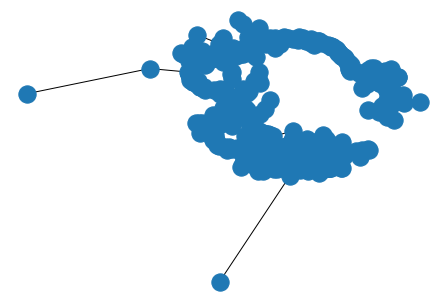

In [195]:
(graph_500, pointsCor3D_500) = getMSTFromDataPoint(points_500, drawMST=True, sampleNumber=500)
                                    

In [196]:
toRemove = []
removedNodeDict = defaultdict(list)
while (True):
    toRemove = []
    for node in graph_500.nodes:
        if(len(graph_500.edges(node)) == 1):
            removedNodeDict[list(graph_500.edges(node))[0][1]].append(node)
            toRemove.append(node)
    #print(len(toRemove))
    if(len(toRemove) == 2):
        break
    for node in toRemove:
        graph_500.remove_node(node)
endpoints = toRemove
print(len(graph_500.nodes))
#print(removedNodeDict)

239


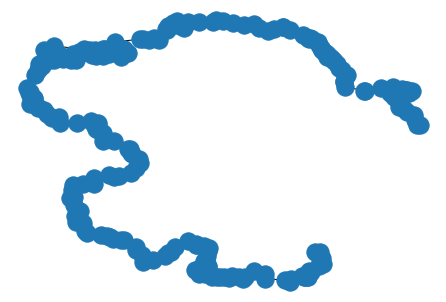

In [197]:
nx.draw(graph_500, dict(enumerate(pointsCor3D_500[:, :2])))

In [198]:
endpoints

[463, 403]

In [199]:
def deleteChild(child:int):
    global removedNodeDict
    graph_500.remove_node(child)
    
    if(child not in removedNodeDict):
        return
    
    for grandChild in removedNodeDict[child]:
        deleteChild(grandChild)

In [200]:
def addBackChildren(parent:int, curDepth:int):
    global removedNodeDict
    
    if(parent not in removedNodeDict):
        return curDepth
    
    if(len(removedNodeDict[point]) == 1):
        child = removedNodeDict[parent][0]
        parent_cor = pointsCor3D_500[parent]
        child_cor = pointsCor3D_500[child]
        graph_500.add_edge(parent, child , distance.euclidean(parent_cor, child_cor))
        return addBackChildren(removedNodeDict[parent][0], curDepth + 1)
    else:
        maxDepth = 0
        curChild = -1
        for child in removedNodeDict[parent]:
            child = removedNodeDict[parent][0]
            parent_cor = pointsCor3D_500[parent]
            child_cor = pointsCor3D_500[child]
            graph_500.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
            childDepth = addBackChildren(removedNodeDict[parent][0], curDepth + 1)
            if(childDepth < maxDepth):
                deleteChild(child)
            else:
                maxDepth = childDepth
                
                if(curChild != -1):
                    deleteChild(curChild)
                    
                curChild = child           
        return maxDepth
            
        
        

In [201]:
addBackChildren(endpoints[0], 0)

3

In [202]:
addBackChildren(endpoints[1], 0)

1

In [203]:
print(len(graph_500.nodes))

241


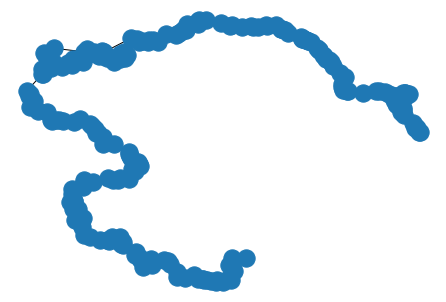

In [194]:
nx.draw(graph_500, dict(enumerate(pointsCor3D_500[:, :2])))

In [167]:
len(graph_500.node())

188

In [204]:
to_display = []
for node in graph_500.nodes:
    to_display.append(pointsCor3D_500[node])
displayPoints(to_display, 1.3)

In [205]:
np.save('./centerline', to_display)